In [2]:
import sys
print(sys.path)

['', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\python36.zip', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\DLLs', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib\\site-packages', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib\\site-packages\\win32', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Loes\\Anaconda2\\envs\\py36\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Loes\\.ipython']


In [1]:
#bron: https://musicinformationretrieval.com/feature_sonification.html

%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (13, 5)

# Step 1: Retrieve Audio

In [5]:
import os

In [12]:
folder = r'C:\Users\Loes\OneDrive\Documenten\Projectstage\heartbeat-sounds\set_a'
files = [filename for filename in files for _, files, _ in os.walk(folder)][:10]

In [16]:
#Load the audio file simple_loop.wav into an array. With amplitude as values
x, sr = librosa.load(os.path.join(folder, files[-9]), sr=None) #sr is sampling rate
#Listen to audio file
ipd.Audio(x, rate=sr)

In [3]:
#Duration audio file
print("duration: ", len(x)/sr,"s")
#Show the sample rate
print("sample rate:", sr, "Hz")

('duration: ', 9, 's')
('sample rate:', 44100, 'Hz')


In [14]:
import matplotlib.pyplot as plt

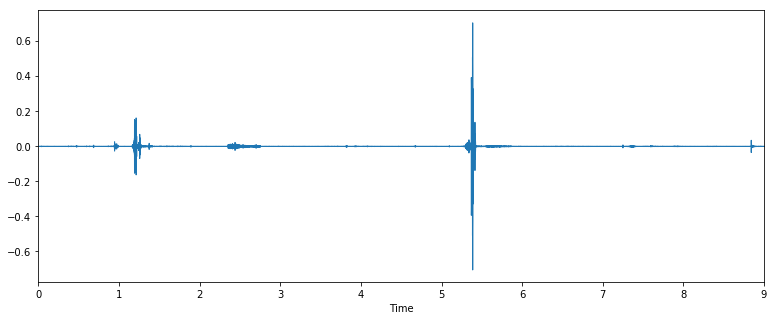

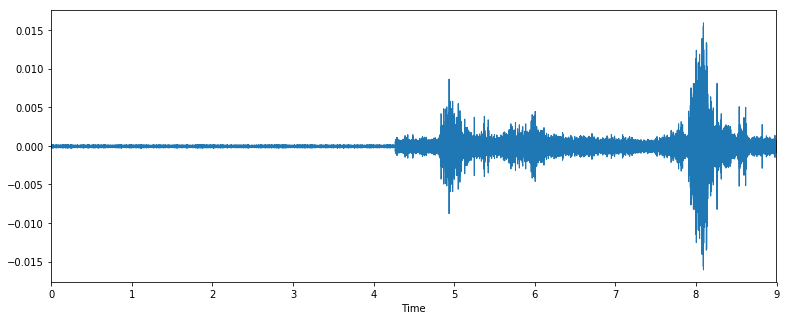

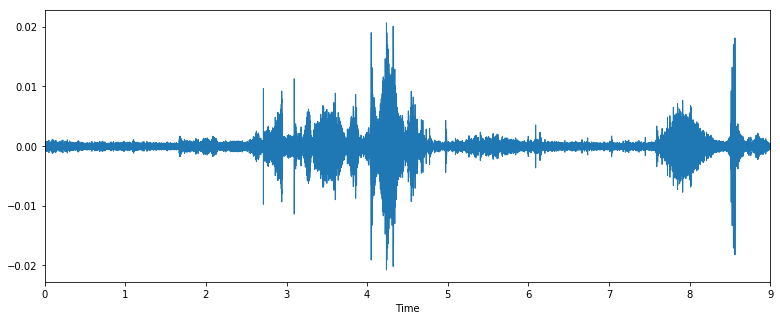

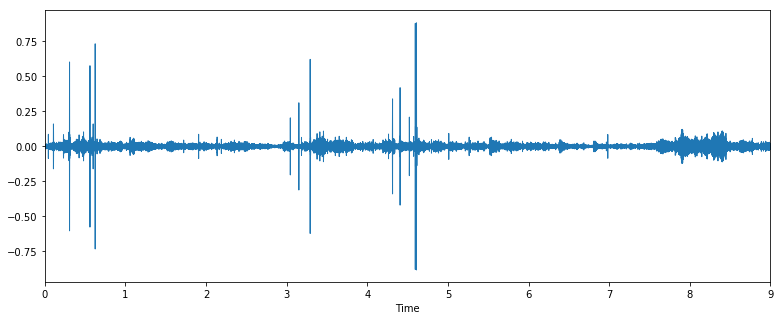

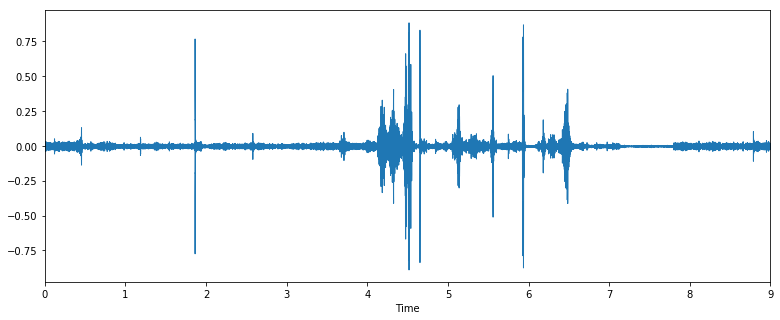

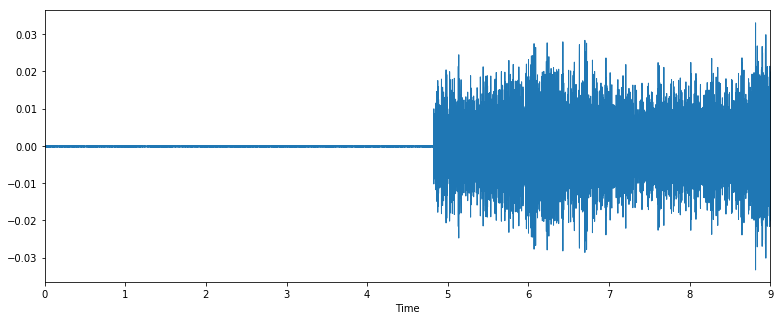

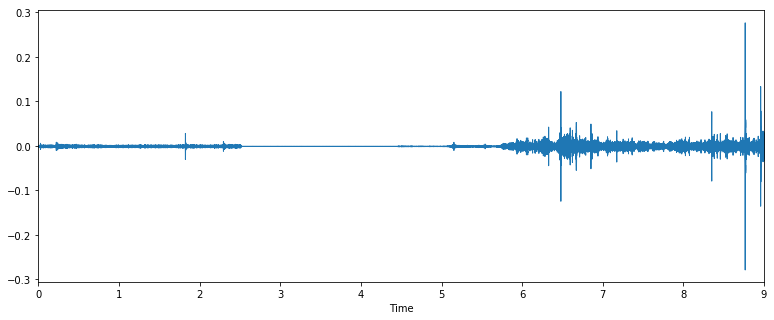

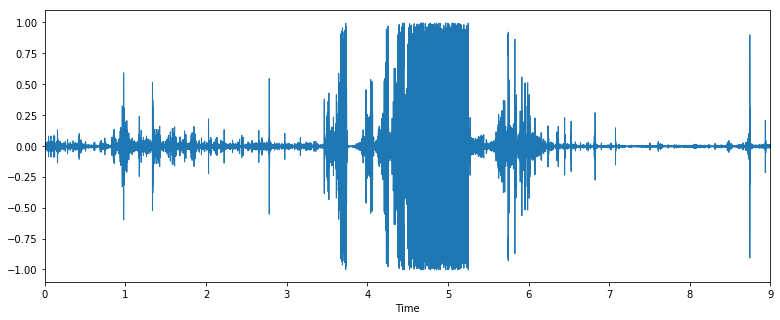

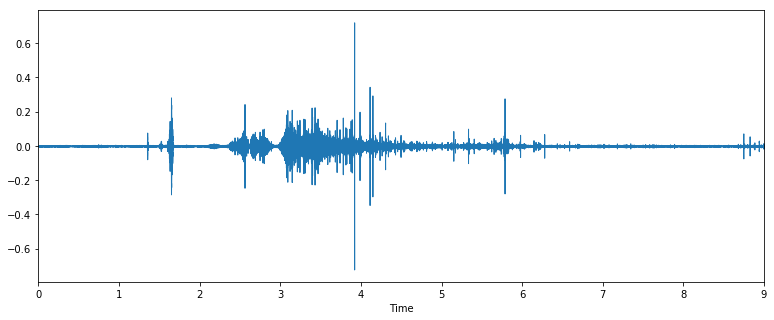

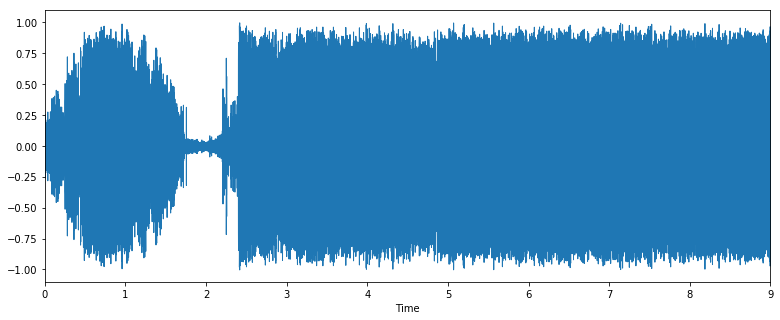

In [15]:
for filename in files:
    x, sr = librosa.load(os.path.join(folder, filename), sr=None) #sr is sampling rate
    plt.figure()
    librosa.display.waveplot(x, sr=sr)

C:\Program Files\Anaconda3\lib\site-packages\librosa\core\spectrum.py:863: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(magphase(D, power=2)[0]) instead.
  warnings.warn('power_to_db was called on complex input so phase '


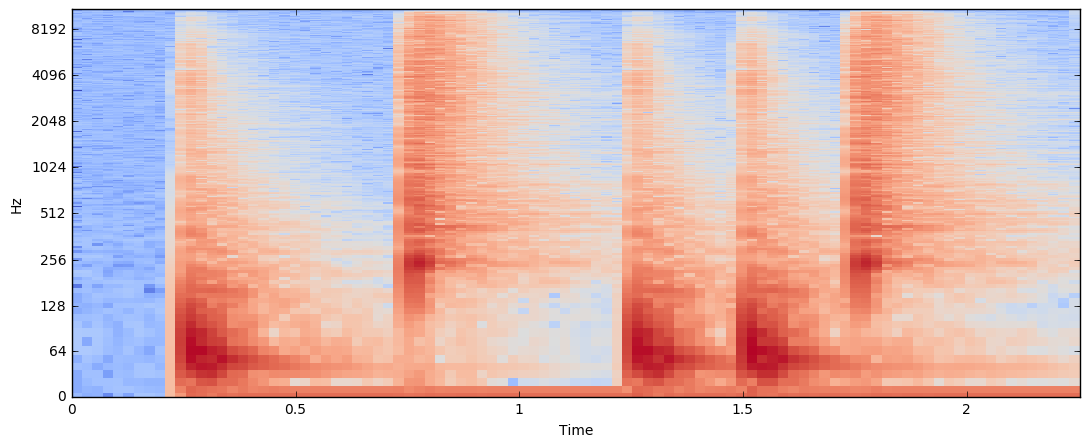

In [92]:
#Compute the short-time Fourier transform:
X = librosa.stft(x)

#For display purposes, compute the log amplitude of the STFT:
Xmag = librosa.power_to_db(X)

#Display the spectrogram
# Play with the parameters, including x_axis and y_axis
librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')

# Step 2: Detect Onsets

In [94]:
#Find the times, in seconds, when onsets occur in the audio signal.
onset_frames = librosa.onset.onset_detect(x, sr=sr)
print(onset_frames)

[12 33 55 66 76]


In [96]:
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
print(onset_times)

[ 0.27863946  0.7662585   1.27709751  1.53251701  1.76471655]


In [97]:
#Convert the onset frames into sample indices.
onset_samples = librosa.frames_to_samples(onset_frames)
print(onset_samples)

[ 6144 16896 28160 33792 38912]


In [98]:
#Play a "beep" at each onset.
# Use the `length` parameter so the click track is the same length as the original signal
clicks = librosa.clicks(times=onset_times, length=len(x))

In [99]:
# Play the click track "added to" the original signal
ipd.Audio(x+clicks, rate=sr)

# Step 3: Segment the Audio

In [108]:
#Save into an array, segments, 100-ms segments beginning at each onset. Dus je krijgt samples van 100 ms.
frame_sz = int(0.100*sr)
segments = numpy.array([x[i:i+frame_sz] for i in onset_samples])

In [109]:
#Here is a function that adds 300 ms of silence onto the end of each segment and concatenates them into one signal.
#Later, we will use this function to listen to each segment, perhaps sorted in a different order.

def concatenate_segments(segments, sr=22050, pad_time=0.300):
    padded_segments = [numpy.concatenate([segment, numpy.zeros(int(pad_time*sr))]) for segment in segments]
    return numpy.concatenate(padded_segments)

In [110]:
concatenated_signal = concatenate_segments(segments, sr)

In [111]:
ipd.Audio(concatenated_signal, rate=sr)

# Step 4: Extract Features

In [113]:
#For each segment, compute the zero crossing rate.
zcrs = [sum(librosa.core.zero_crossings(segment)) for segment in segments]
print(zcrs)

[11, 570, 11, 10, 568]


In [115]:
#Use argsort to find an index array, ind, such that segments[ind] is sorted by zero crossing rate.
ind = numpy.argsort(zcrs)
print(ind)

[3 0 2 4 1]


In [116]:
#Sort the segments by zero crossing rate, and concatenate the sorted segments.
concatenated_signal = concatenate_segments(segments[ind], sr)

# Step 5: Listen to Segments

In [117]:
#Listen to the sorted segments. What do you hear?
ipd.Audio(concatenated_signal, rate=sr)

#### Repeat the steps above using other features from librosa.feature, e.g. rmse, spectral_centroid, spectral_bandwidth.